In [12]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_data/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/MRI_data/Testing'

In [14]:
#list of categories
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

#image size for resizing
IMG_SIZE = 224

--------------------------------------------------------------------------------

<h4>CROP and RESIZE</h4>

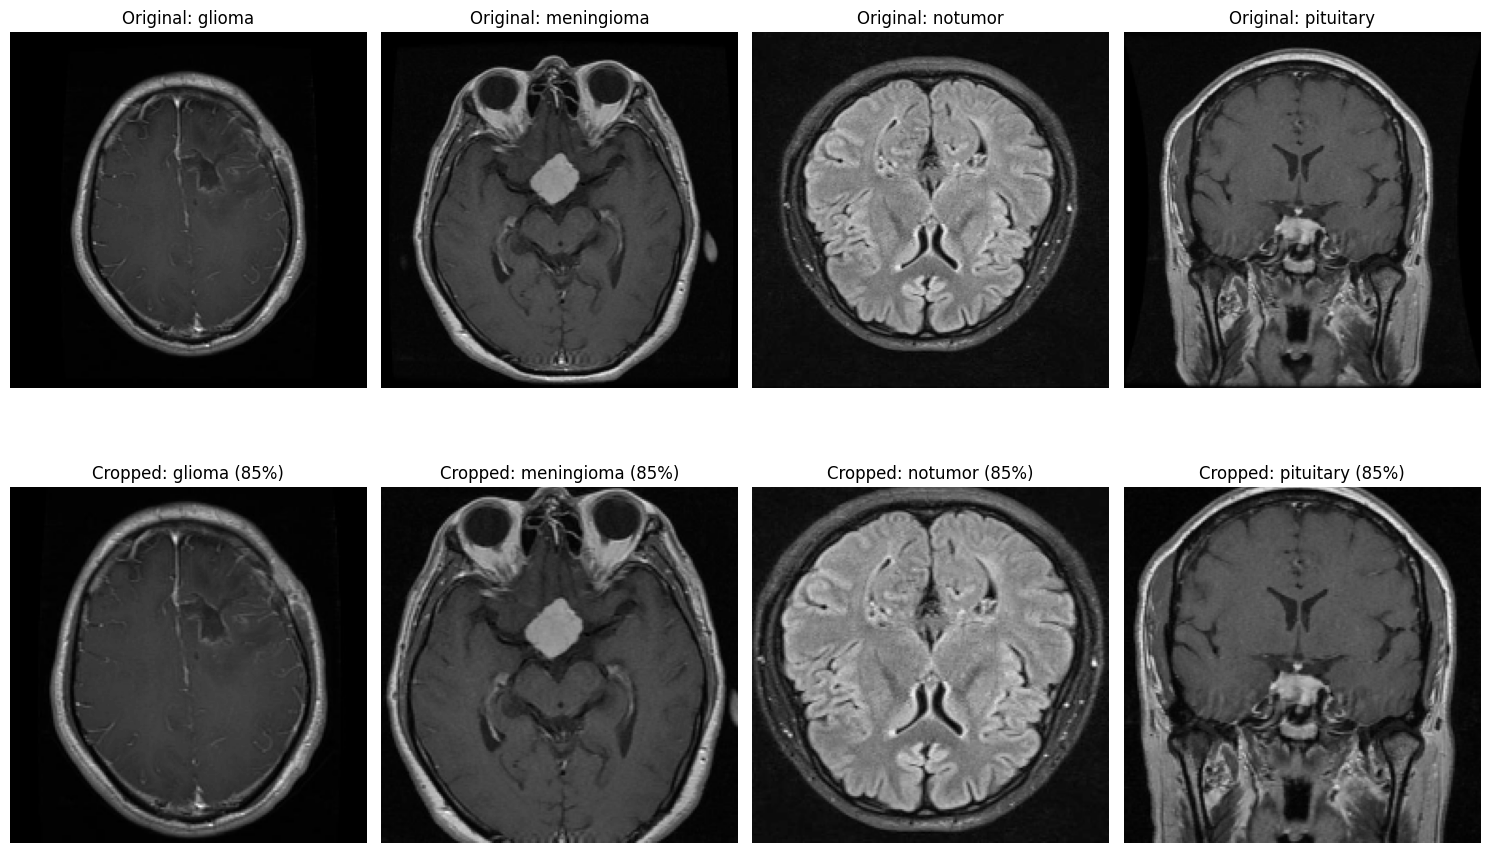

In [15]:
#function to crop the image
def crop_image(img):
    height, width = img.shape
    crop_height = int(height * 0.85)
    crop_width = int(width * 0.85)
    start_row = (height - crop_height) // 2
    start_col = (width - crop_width) // 2
    cropped_img = img[start_row:start_row + crop_height, start_col:start_col + crop_width]
    return cropped_img

#display cropped images
def display_cropped_images():
    plt.figure(figsize=(15, 10))

    for idx, category in enumerate(categories):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        img_path = os.path.join(category_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Crop the image (retain 85%)
        cropped_img = crop_image(resized_img)

        # Plot original image
        plt.subplot(2, len(categories), idx + 1)
        plt.imshow(resized_img, cmap='gray')
        plt.title(f'Original: {category}')
        plt.axis('off')

        # Plot cropped image
        plt.subplot(2, len(categories), idx + 1 + len(categories))
        plt.imshow(cropped_img, cmap='gray')
        plt.title(f'Cropped: {category} (85%)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_cropped_images()

--------------------------------------------------------------------------------

<h4>CONTRAST ENHANCEMENT - Histogram Equalization and CLAHE</h4>

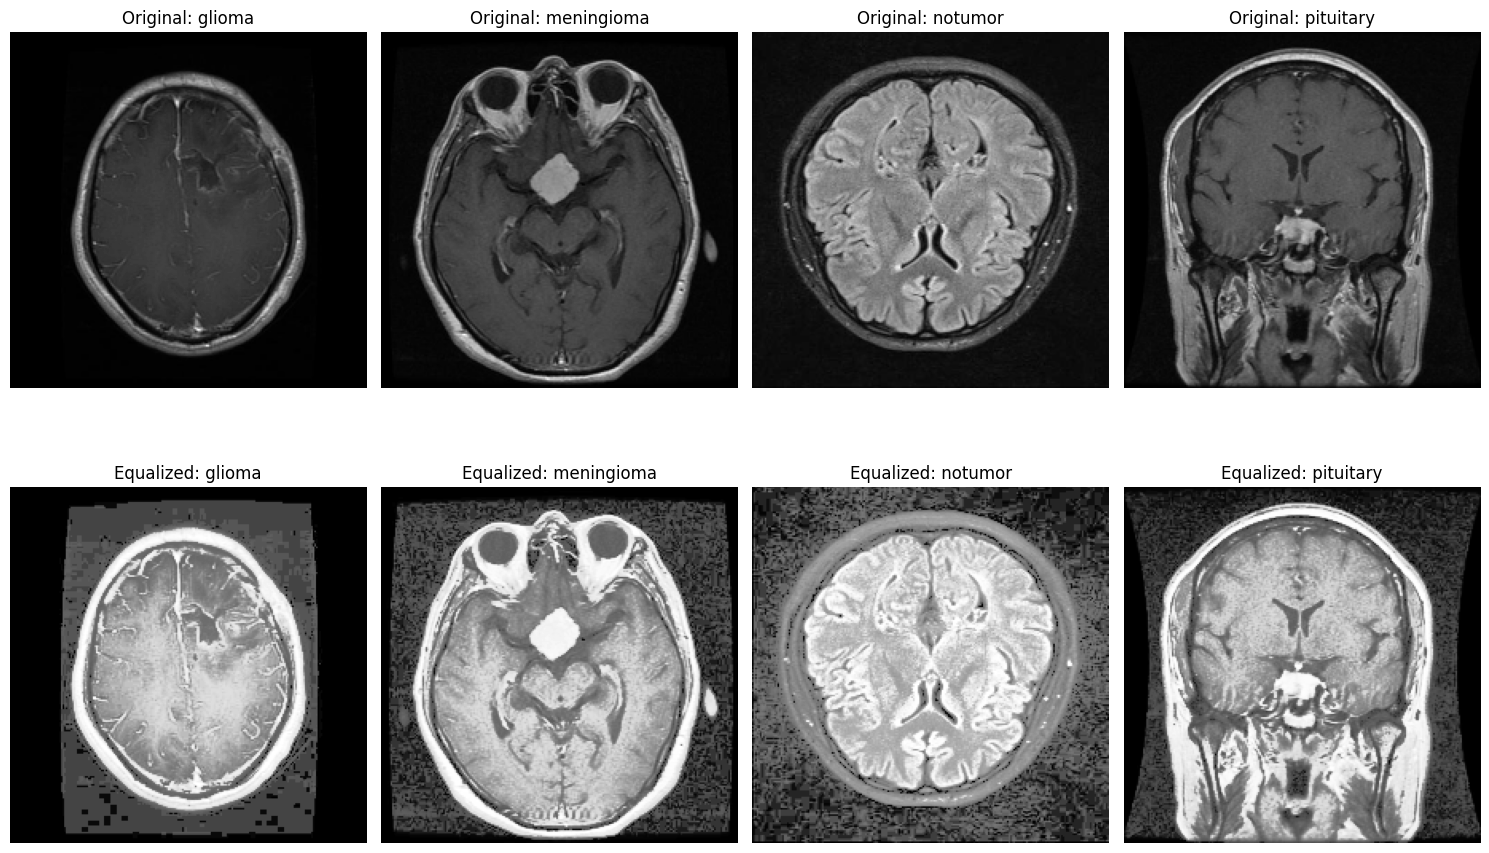

In [16]:
#function to equalize histogram
def equalize_image(img):
    return cv2.equalizeHist(img)

#display histogram equalized images
def display_histogram_equalization():
    plt.figure(figsize=(15, 10))  # Consistent figure size

    for idx, category in enumerate(categories):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        img_path = os.path.join(category_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Equalize the histogram of the image
        equalized_img = equalize_image(resized_img)

        # Plot original image
        plt.subplot(2, len(categories), idx + 1)
        plt.imshow(resized_img, cmap='gray')
        plt.title(f'Original: {category}')
        plt.axis('off')

        # Plot equalized image
        plt.subplot(2, len(categories), idx + 1 + len(categories))
        plt.imshow(equalized_img, cmap='gray')
        plt.title(f'Equalized: {category}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_histogram_equalization()

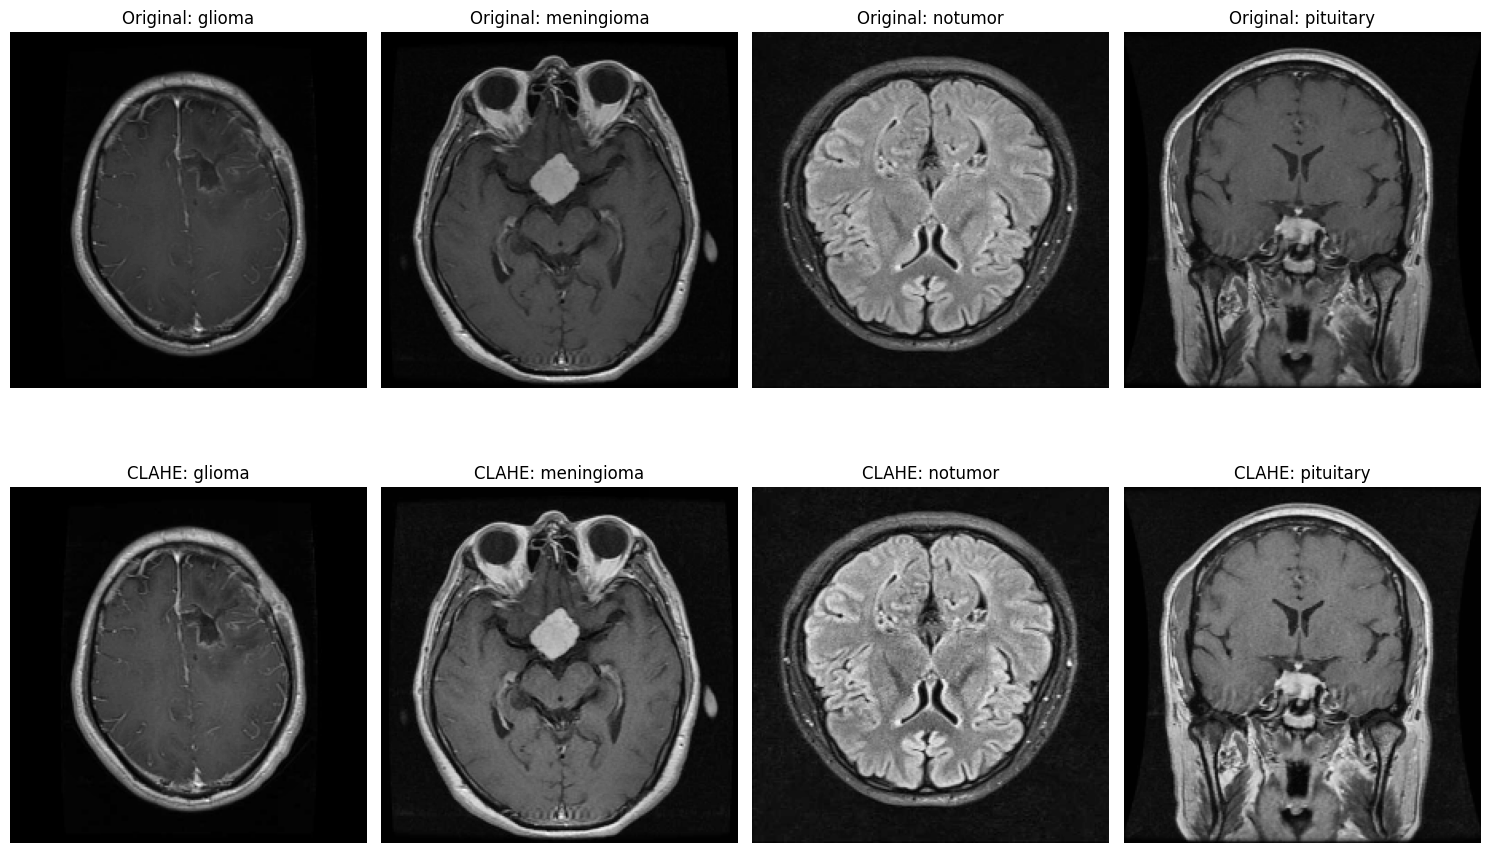

In [17]:
#function to apply CLAHE
def clahe(img):
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    return clahe.apply(img)

#display CLAHE images
def display_clahe():
    plt.figure(figsize=(15, 10))  # Consistent figure size

    for idx, category in enumerate(categories):
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        img_path = os.path.join(category_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Apply CLAHE to the image
        clahe_img = clahe(resized_img)

        # Plot original image
        plt.subplot(2, len(categories), idx + 1)
        plt.imshow(resized_img, cmap='gray')
        plt.title(f'Original: {category}')
        plt.axis('off')

        # Plot CLAHE image
        plt.subplot(2, len(categories), idx + 1 + len(categories))
        plt.imshow(clahe_img, cmap='gray')
        plt.title(f'CLAHE: {category}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_clahe()

The contrast of the MRI images as well as the details retained are better using the CLAHE rather than simple Histrogram Equalization.

--------------------------------------------------------------------------------

<h4>DATA AUGMENTATION -</h4>

Displaying Augmentations of MRI images.
Vertical flipping, Horizontal flipping and Image Zoom.

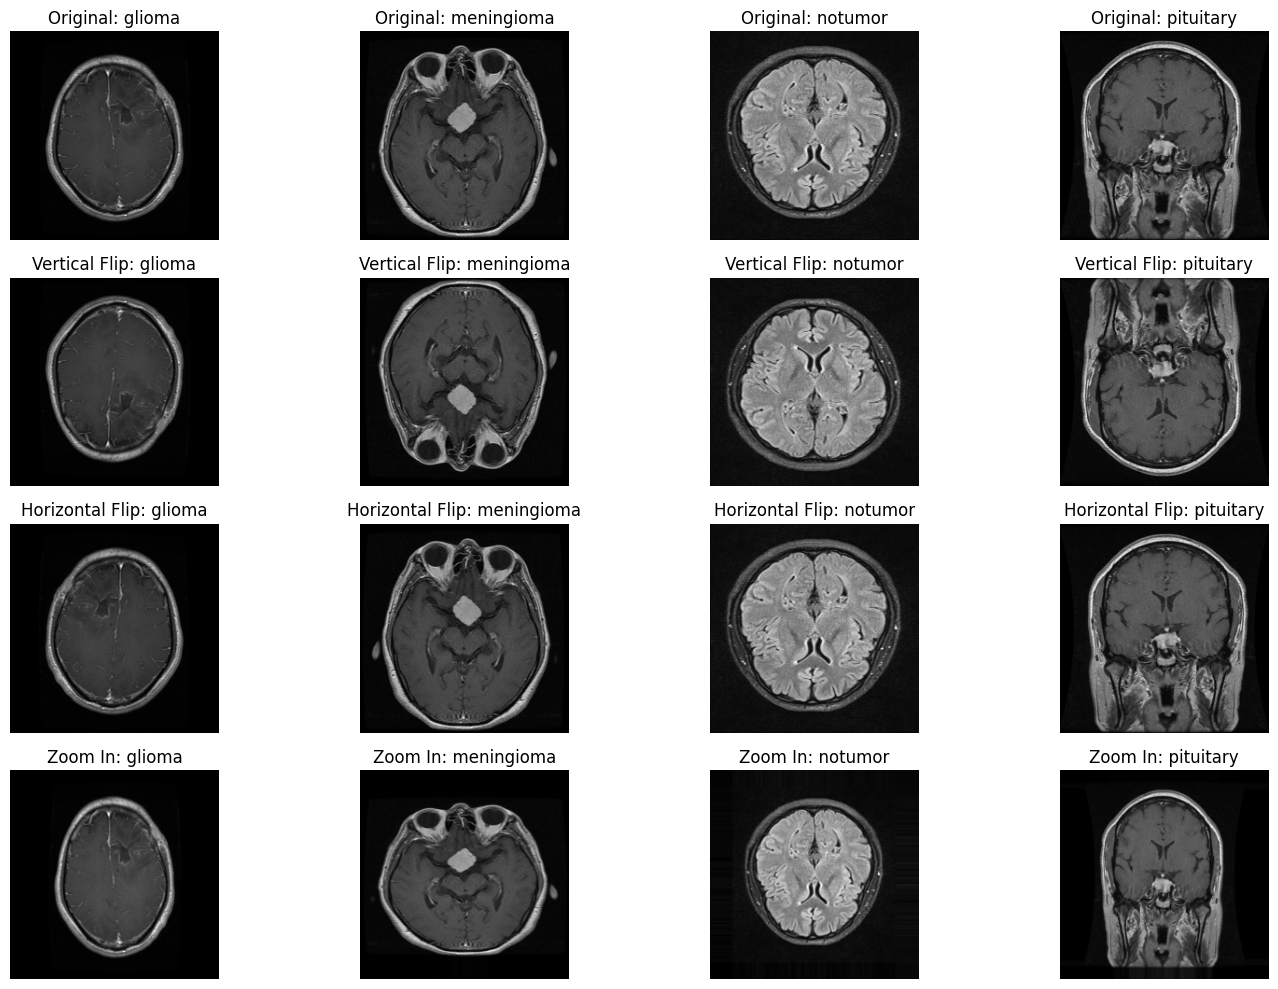

In [18]:
#preprocess the input image
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, img_size)
    img_normalized = img_resized / 255.0
    img_normalized = np.expand_dims(img_normalized, axis=(0, -1))
    return img_resized, img_normalized

#generate augmentations (vertical flip, horizontal flip, zoom)
def generate_augmentations(img_normalized):
    # Vertical Flip
    datagen_vflip = ImageDataGenerator(vertical_flip=True)
    vflip_img = next(datagen_vflip.flow(img_normalized, batch_size=1, shuffle=False))[0]
    vflip_img = np.squeeze(vflip_img)

    # Horizontal Flip
    datagen_hflip = ImageDataGenerator(horizontal_flip=True)
    hflip_img = next(datagen_hflip.flow(img_normalized, batch_size=1, shuffle=False))[0]
    hflip_img = np.squeeze(hflip_img)

    # Zoom
    datagen_zoom = ImageDataGenerator(zoom_range=0.3)
    zoom_img = next(datagen_zoom.flow(img_normalized, batch_size=1, shuffle=False))[0]
    zoom_img = np.squeeze(zoom_img)

    return vflip_img, hflip_img, zoom_img

#display original and augmented images
def display_augmentations():
    plt.figure(figsize=(15, 10))

    for idx, category in enumerate(categories):
        # Get the path of the first image in the category
        category_path = os.path.join(train_dir, category)
        image_files = os.listdir(category_path)

        # Load the first image in the category
        img_path = os.path.join(category_path, image_files[0])

        # Preprocess image (resize and normalize)
        original_image, img_normalized = preprocess_image(img_path)

        # Generate augmentations
        vflip_img, hflip_img, zoom_img = generate_augmentations(img_normalized)

        # Plot original image
        plt.subplot(4, len(categories), idx + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title(f'Original: {category}')
        plt.axis('off')

        # Plot vertically flipped image
        plt.subplot(4, len(categories), idx + 1 + len(categories))
        plt.imshow(vflip_img, cmap='gray')
        plt.title(f'Vertical Flip: {category}')
        plt.axis('off')

        # Plot horizontally flipped image
        plt.subplot(4, len(categories), idx + 1 + 2 * len(categories))
        plt.imshow(hflip_img, cmap='gray')
        plt.title(f'Horizontal Flip: {category}')
        plt.axis('off')

        # Plot zoomed-in image
        plt.subplot(4, len(categories), idx + 1 + 3 * len(categories))
        plt.imshow(zoom_img, cmap='gray')
        plt.title(f'Zoom In: {category}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_augmentations()

--------------------------------------------------------------------------------

<h3>Preprocessing Pipeline -</h3>
The pipeline contains the following preprocessing techniques :

1. **Cropping**
2. **Resizing**
3. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**
4. **Normalization**
5. **Data Augmentation**

**Pipeline : cropping - resizing - CLAHE - normalization - augmentation**

In [19]:
#function to apply image processing techniques on MRI
def image_processing(brain_image):
    # Crop the image (retain 85%)
    height, width = brain_image.shape
    crop_height = int(height * 0.85)
    crop_width = int(width * 0.85)
    start_row = (height - crop_height) // 2
    start_col = (width - crop_width) // 2
    cropped_image = brain_image[start_row:start_row + crop_height, start_col:start_col + crop_width]

    # Resize the image to the desired size
    resized_image = cv2.resize(cropped_image, (224, 224))

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))
    clahe_image = clahe.apply(resized_image)

    # Normalize the image and add a channel dimension
    normalized_image = clahe_image / 255.0
    normalized_image = np.expand_dims(normalized_image, axis=-1)

    return normalized_image

# #function to Augment images
# def augment_data(image):
#     datagen = ImageDataGenerator(
#         rotation_range=30,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True
#     )

#     # Reshape the image to include batch size
#     image = np.expand_dims(image, axis=0)

#     # Generate augmented images
#     augmented_images = []
#     for _ in range(4):
#         aug_iter = datagen.flow(image, batch_size=1)
#         augmented_image = next(aug_iter)[0]
#         augmented_images.append(augmented_image.squeeze())

#     return augmented_images

In [20]:
#destination directories for processed images
preprocess_train = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v1/Training'
preprocess_test = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v1/Testing'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Ensure the output directories exist
def create_output_dirs(base_dir, categories):
    for category in categories:
        os.makedirs(os.path.join(base_dir, category), exist_ok=True)

create_output_dirs(preprocess_train, categories)
create_output_dirs(preprocess_test, categories)

In [21]:
#function to save processed image
def save_image(image, save_path):
    image_to_save = (image * 255).astype(np.uint8)
    cv2.imwrite(save_path, image_to_save)

#function for the image processing pipeline (cropping, resizing, CLAHE, normalization)
def preprocess(image_path, save_dir):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    processed_image = image_processing(img)
    save_image(processed_image, save_dir)

def process_images(input_dir, output_dir_pipeline2):
    for category in categories:
        category_dir = os.path.join(input_dir, category)
        output_dir_p2 = os.path.join(output_dir_pipeline2, category)

        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)

            save_path = os.path.join(output_dir_p2, img_name)
            preprocess(img_path, save_path)

process_images(train_dir, preprocess_train)
process_images(test_dir, preprocess_test)

print("Process Complete !!")

Process Complete !!
